<a href="https://colab.research.google.com/github/Mai-Binh-Nam/Hand-on_DataAnalysisVEF/blob/master/VEF_Academy_Lecture_Time_Series_Handson_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 808kB 13.5MB/s 
     |████████████████████████████████| 8.7MB 24.5MB/s 
     |████████████████████████████████| 2.1MB 34.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

In [ ]:
print(data.head())
print('-'*30)
print('Number of data points: {}'.format(data.shape))

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
------------------------------
Number of data points: (144, 2)


In [ ]:
print('Time period start: {}\nTime period end: {}'.format(data.Month.min(),data.Month.max()))

Time period start: 1949-01
Time period end: 1960-12


In [ ]:
# Convert to datetime format
data['year'] = pd.to_datetime(data['Month'], format='%Y-%m')

# For easily manipulation in further, we set index as  the datetime column
data = data.set_index('year')
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=144, freq=None)

### Some indexing techniques

In [ ]:
ts = data['#Passengers']
# Specific the index as a string constant
print(ts['1949-01-01'])

# Import the datetime library and use 'datetime' function
from datetime import datetime
print(ts[datetime(1949,1,1)])

# Specify the entire range
print(ts['1949-01-01':'1949-05-01'])

112
112
year
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


### Data preprocessing & Visualization


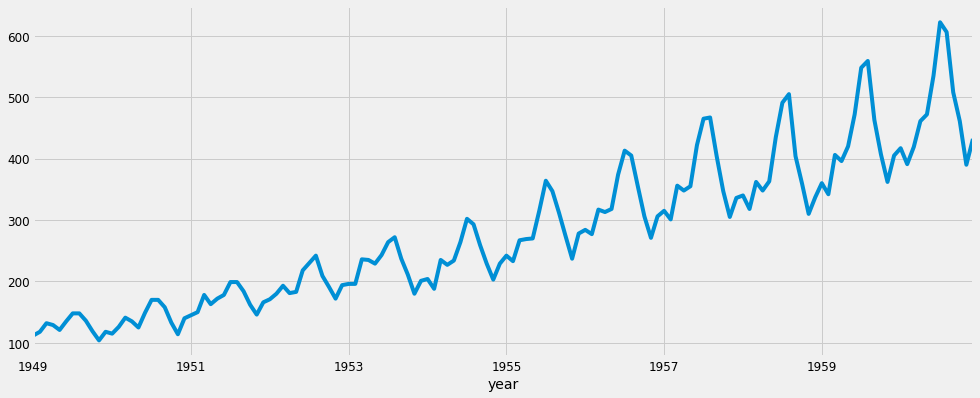

In [ ]:
ts.plot(figsize=(15, 6))
plt.show()

From the visualization, it is clearly that data has increasing trend and seasonality which means this time series is non-stationary. We can use Dickey-Fuller Test to confirm this hypothesis. We can reject the null hypothesis if

- the ‘Test Statistic’ is less than the ‘Critical Value’
- or p-value is large

**Note:**
Ho: the series is non-stationary

In [ ]:
def test_stationarity(time_series):
  #Perform Dickey-Fuller test:
  print('Results of Dickey-Fuller Test:')
  adfuller_test = adfuller(time_series, autolag='AIC')
  adfuller_test_output = pd.Series(adfuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in adfuller_test[4].items():
      adfuller_test_output['Critical Value (%s)'%key] = value

  print(adfuller_test_output)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Another way to check the time series is stationarity or not is using ACF and PACF plots.

- If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points

- A 95% confidence interval is set by default, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke


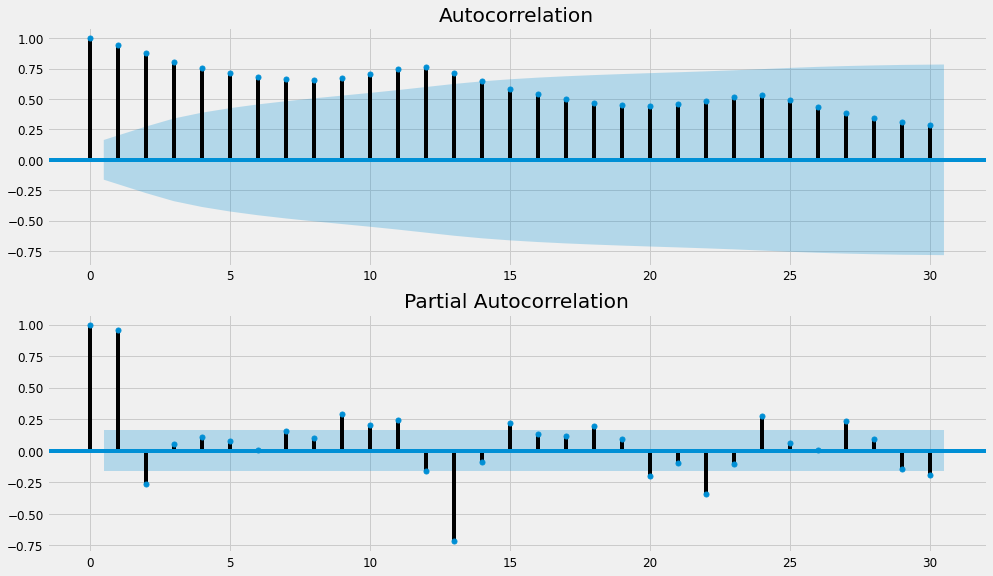

In [ ]:
plt.figure(figsize=(15,9))
plt.subplot(211)
plot_acf(ts, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(ts, ax=plt.gca(), lags = 30)
plt.show()

### Transform to Stationary

- Differencing
- Decomposition

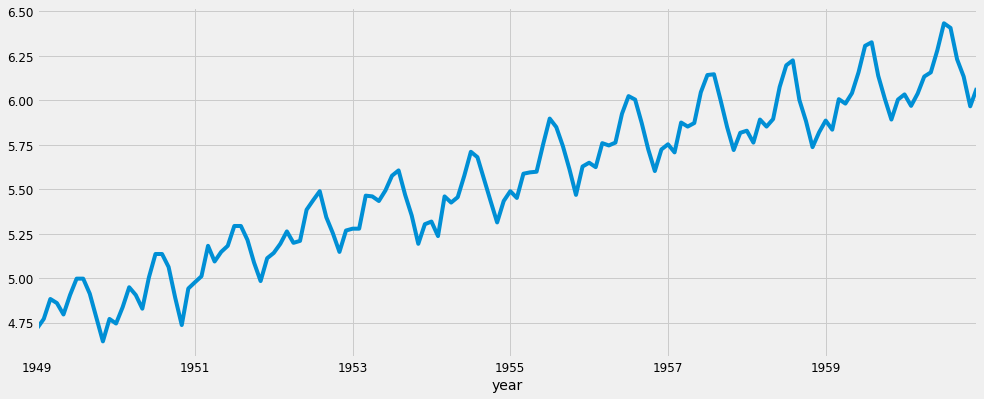

In [ ]:
# First we penalize higher values by taking log
ts_log = np.log(ts)
ts_log.plot(figsize=(15, 6))
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


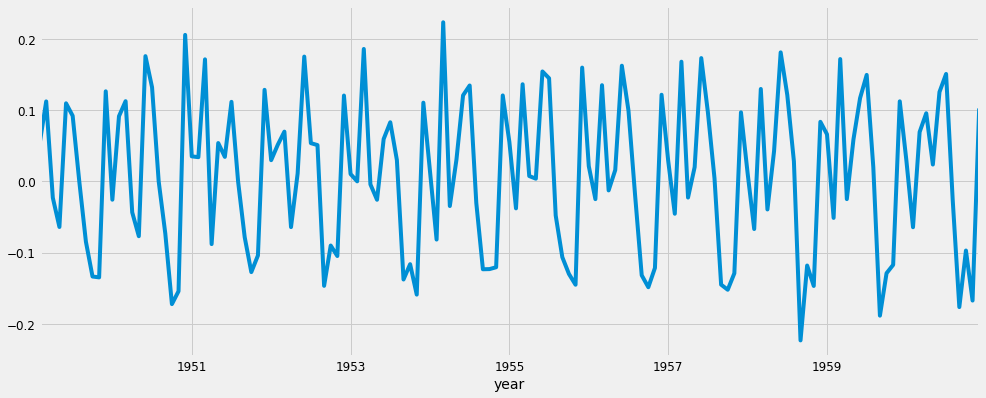

In [ ]:
# Take 1st differencing on transformed time series
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True) # drop NA values
ts_log_diff.plot(figsize=(15, 6))

test_stationarity(ts_log_diff.dropna()) #.dropna(inplace=True))

Results of Dickey-Fuller Test:
Test Statistic                  -3.167907
p-value                          0.021919
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


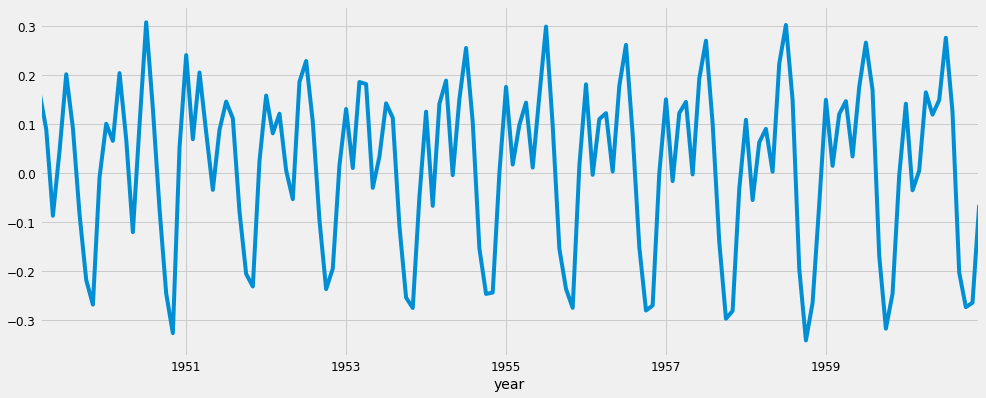

In [ ]:
# Take 2nd differencing on transformed time series - we get better result
ts_log_diff = ts_log - ts_log.shift(2)
ts_log_diff.dropna(inplace=True)  # drop NA values
ts_log_diff.plot(figsize=(15, 6))

test_stationarity(ts_log_diff.dropna()) #.dropna(inplace=True))

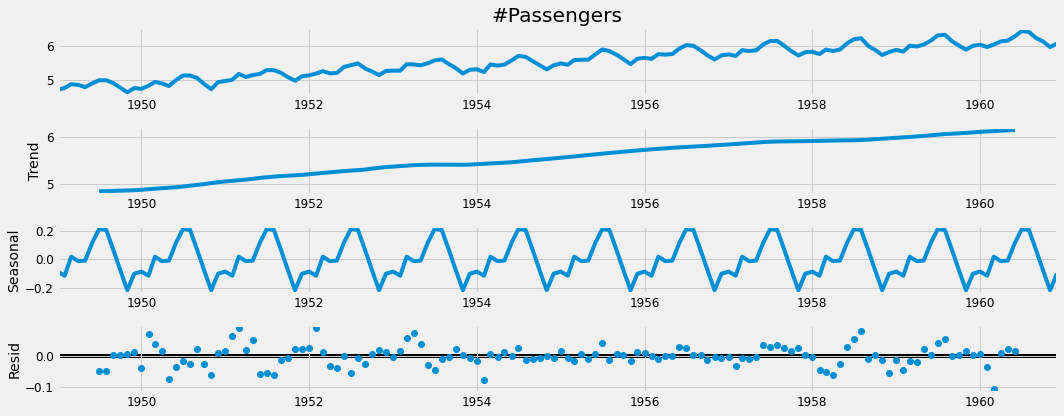

In [ ]:
# Using decomposition method to decompose time series
from pylab import rcParams
rcParams['figure.figsize'] = 15, 6

decomposition = sm.tsa.seasonal_decompose(ts_log, model = 'additive')
fig = decomposition.plot()
plt.show()


### Forcasting Time series

- Autoregression - AR(p) models the next steps in the sequence as a linear function of the observations at prior time steps

- Moving Average - MA(q)

- Autoregressive Moving Average - ARMA(p,q)

- Autoregressive Integrated Moving Average - ARIMA(p,d,q)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


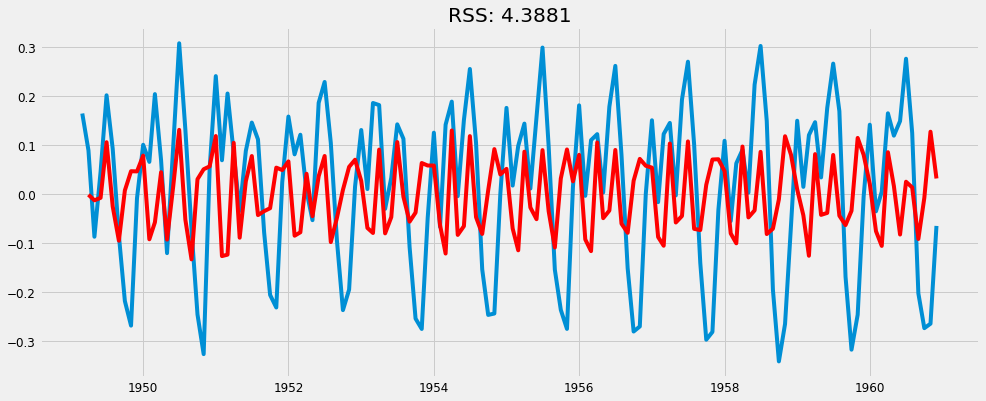

In [ ]:
# Build AR(p) model
ar_model = ARIMA(ts_log_diff, order=(2, 1, 0))
ar_model_fit = ar_model.fit()


plt.plot(ts_log_diff)
plt.plot(ar_model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((ar_model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 5.7352')

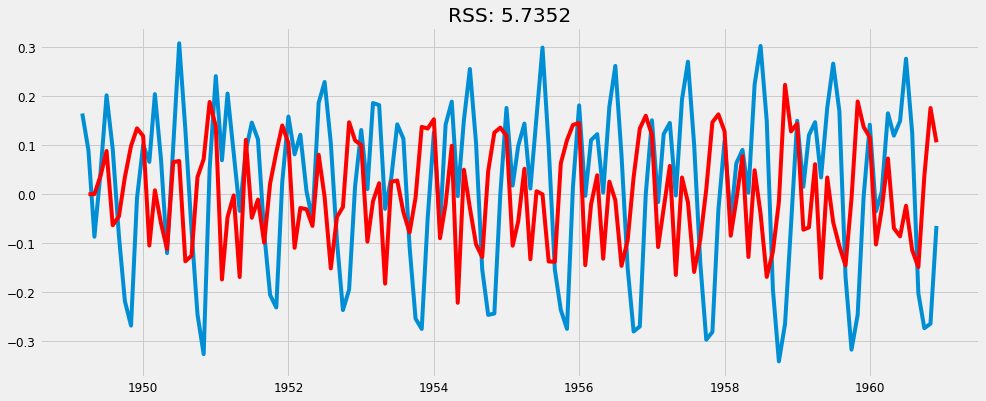

In [ ]:
# Build MA model
ma_model = ARIMA(ts_log_diff, order=(0, 1, 2))
ma_model_fit = ma_model.fit(disp=False)


plt.plot(ts_log_diff)
plt.plot(ma_model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((ma_model_fit.fittedvalues-ts_log_diff)**2))

In [ ]:
# Read summary of MA model
ma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.#Passengers   No. Observations:                  141
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 111.224
Method:                       css-mle   S.D. of innovations              0.107
Date:                Mon, 12 Oct 2020   AIC                           -214.447
Time:                        23:38:01   BIC                           -202.652
Sample:                    04-01-1949   HQIC                          -209.654
                         - 12-01-1960                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0002      0.000     -0.407      0.684      -0.001       0.001
ma.L1.D.#Passengers  1.557e-06      0.026    6.1e-05      1.000      -0.050       0.050
ma.L2.D.#Passengers    -1.0000      0.026    -39.174      0.000      -1.050      -0.950
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0000           +0.0000j            1.0000            0.5000
MA.2            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5453')

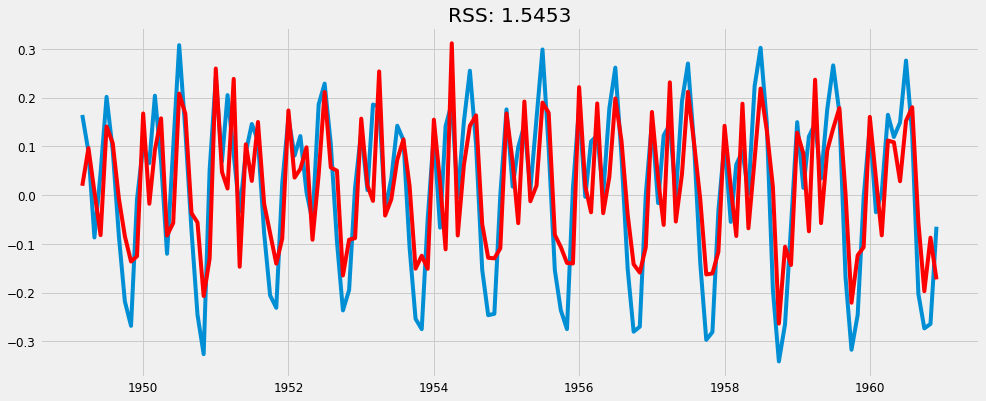

In [ ]:
# Build ARMA model
arma_model = ARMA(ts_log_diff, order=(2, 1))
arma_model_fit = arma_model.fit(disp=False)

plt.plot(ts_log_diff)
plt.plot(arma_model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((arma_model_fit.fittedvalues-ts_log_diff)**2))

In [ ]:
# Read summary of ARMA model
arma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  142
Model:                     ARMA(2, 1)   Log Likelihood                 119.146
Method:                       css-mle   S.D. of innovations              0.102
Date:                Mon, 12 Oct 2020   AIC                           -228.291
Time:                        23:38:13   BIC                           -213.512
Sample:                    03-01-1949   HQIC                          -222.286
                         - 12-01-1960                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0191      0.018      1.041      0.298      -0.017       0.055
ar.L1.#Passengers     0.2355      0.083      2.837      0.005       0.073       0.398
ar.L2.#Passengers    -0.1718      0.084     -2.054      0.040      -0.336      -0.008
ma.L1.#Passengers     1.0000      0.020     51.279      0.000       0.962       1.038
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6853           -2.3130j            2.4124           -0.2042
AR.2            0.6853           +2.3130j            2.4124            0.2042
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

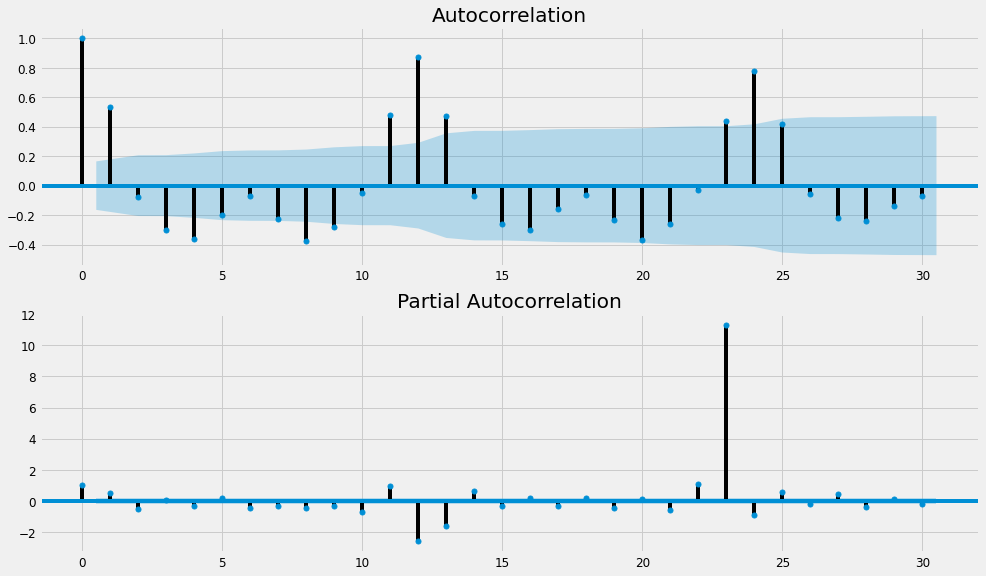

In [ ]:
# Check ACF and PACF after differencing
plt.figure(figsize=(15,9))
plt.subplot(211)
plot_acf(ts_log_diff, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(ts_log_diff, ax=plt.gca(), lags = 30)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 2.6658')

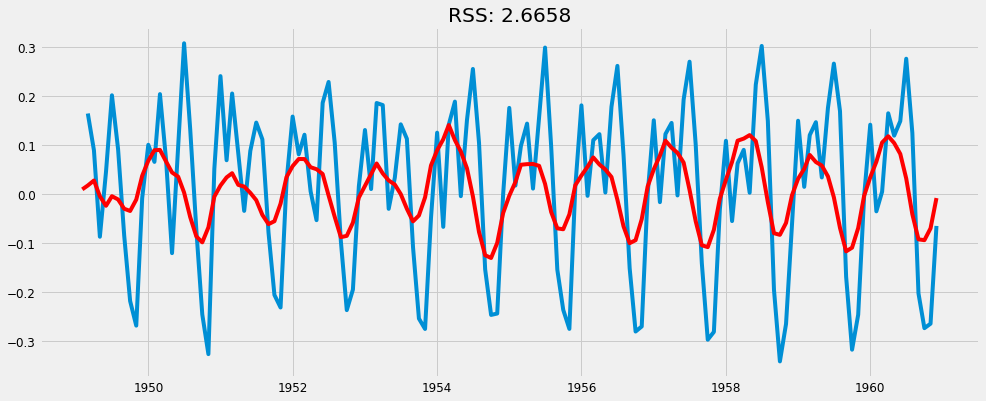

In [ ]:
# Build ARIMA model
arima_model = ARIMA(ts_log, order=(2, 1, 2))  
arima_model_fit = arima_model.fit(disp=-1)  

plt.plot(ts_log_diff)
plt.plot(arima_model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((arima_model_fit.fittedvalues-ts_log_diff)**2))

In [ ]:
# Read summary of ARIMA model
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Mon, 12 Oct 2020   AIC                           -287.281
Time:                        23:38:23   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.#Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.#Passengers    -0.8946      0.039    -23.127      0.000      -0.970      -0.819
ma.L1.D.#Passengers    -1.8270      0.036    -51.303      0.000      -1.897      -1.757
ma.L2.D.#Passengers     0.9245      0.036     25.568      0.000       0.854       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9106           -0.5372j            1.0573           -0.0848
AR.2            0.9106           +0.5372j            1.0573            0.0848
MA.1            0.9881           -0.3245j            1.0400           -0.0505
MA.2            0.9881           +0.3245j            1.0400            0.0505
-----------------------------------------------------------------------------
"""

### Convert predicted values to original scale

In [ ]:
predictions_ARIMA_diff = pd.Series(arima_model_fit.fittedvalues, copy=True)
predictions_ARIMA_diff.head()  # these are fitted values on the transformed data

year
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [ ]:
# Cumulative sum to reverse differencing
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

# Adding 1st month value - was previously removed while differencing
predictions_ARIMA_log = pd.Series(ts_log[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,
                                                  fill_value=0)
predictions_ARIMA_log.head()

year
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1046')

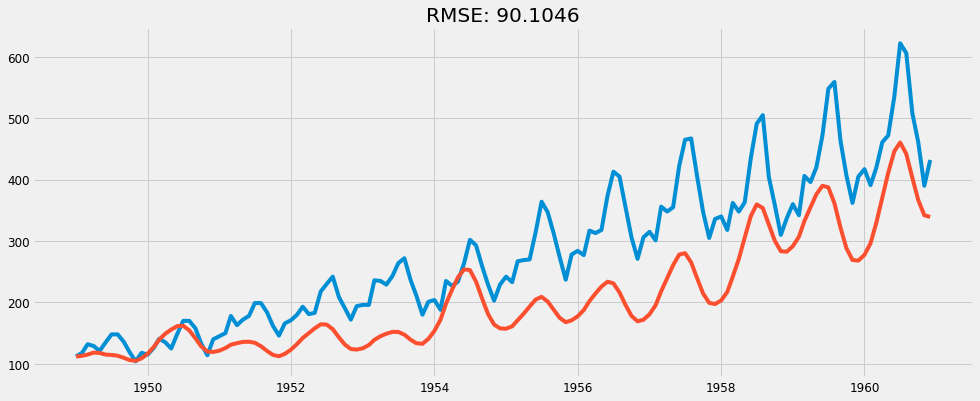

In [ ]:
# Take exponential to reverse Log Transform
predictions_ARIMA = np.exp(predictions_ARIMA_log)

# Compare with the original time series
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

### Auto ARIMA

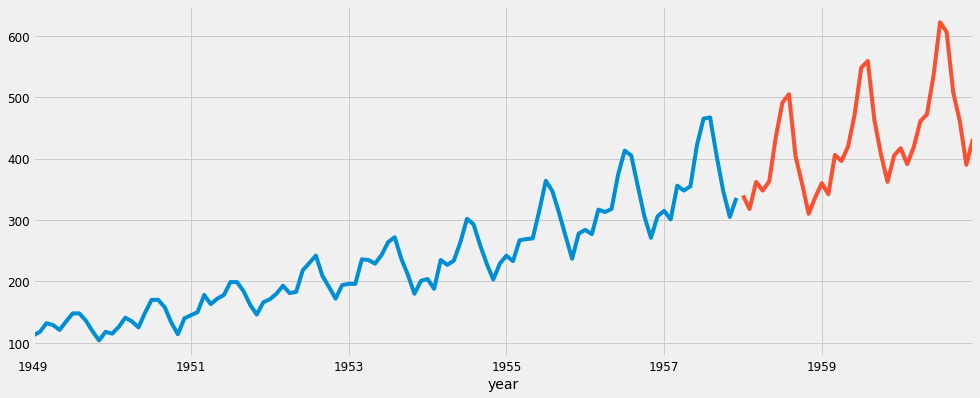

In [ ]:
# Divide into train and validation set
train = ts[:int(0.75*(len(ts)))]
valid = ts[int(0.75*(len(ts))):]

train.plot()
valid.plot()

In [ ]:
# Build ARIMA model using Auto Arima
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=959.218, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1002.826, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=996.373, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=991.646, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1001.531, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=988.670, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=983.832, Time=0.13 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.247 seco

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

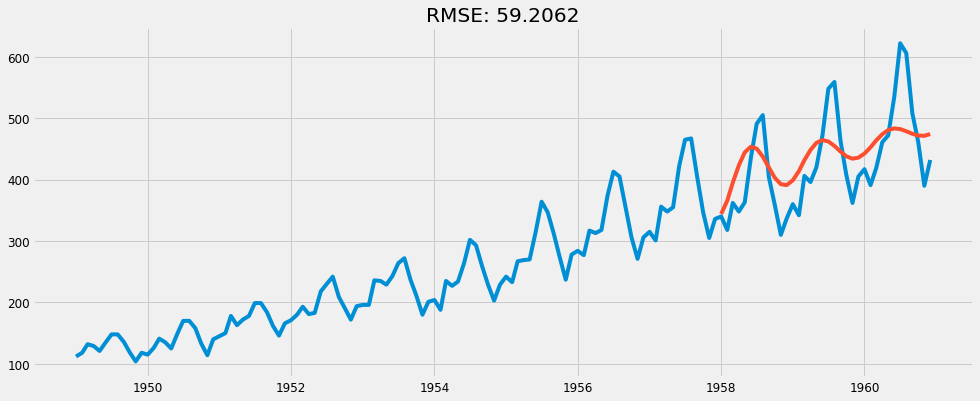

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(ts, label='Train')
plt.plot(forecast, label='Prediction')
plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(ts[valid.index.min(): valid.index.max()],
                                                   forecast)))
plt.show()